# Problema de Otimização do Transporte

## 1 - Natureza do Problema
Trata-se de um problema de maximização do lucro

In [1]:
import random
import numpy
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# INIT
toolbox = base.Toolbox()

# Definindo a natureza do problema. No caso um problema de maximização
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

## 2 - Variáveis e Codificação
- A codificação utilizada será um comossomo com 70 genes onde cada gene representa a rota que o caminhão está alocado.
- Como temos 25 rotas possíveis para cada caminhão precisaremos 5 bits para cada gene e logo teremos um cromossomo de tamanho 350 ($5*70$). Optou-se utilizar somente as rotas com valor ao invés de todas as possíveis, para reduzir o espaço de busca, bem como não gerar soluções inválidas
- O espaço de busca  total é de aproximadamente $2,3*10^{105}$

In [2]:
#MONTADORA-DESTINO
rotas = [
        'GMS-RIO','GMS-BSB','GMS-CNF','GMS-CWB','GMS-REC',
        'RNT-SAO','RNT-RIO','RNT-CNF','RNT-POA',
        'FRD-RIO','FRD-CWB','FRD-POA',
        'FAT-SAO','FAT-BSB','FAT-CWB','FAT-REC',
        'VKW-RIO','VKW-BSB','VKW-CWB','VKW-POA',
        'HYD-SAO','HYD-CNF','HYD-CWB','HYD-REC','HYD-POA']

# Demanda mensal dos veículos de cada MONTADORA-CENTRO_CONSUMIDOR
demandas = {
        'GMS-RIO':1701, 'GMS-BSB':1039, 'GMS-CNF':1072, 'GMS-CWB':975, 'GMS-REC':374, 
        'RNT-SAO':1903, 'RNT-RIO':684 , 'RNT-CNF':431 , 'RNT-POA':218, 
        'FRD-RIO':953 , 'FRD-CWB':547 , 'FRD-POA':304 , 
        'FAT-SAO':5246, 'FAT-BSB':1152, 'FAT-CWB':1081, 'FAT-REC':414, 
        'VKW-RIO':1689, 'VKW-BSB':1031, 'VKW-CWB':968 , 'VKW-POA':538, 
        'HYD-SAO':1360, 'HYD-CNF':308 , 'HYD-CWB':281 , 'HYD-REC':108, 'HYD-POA':156}

# Menor distância entre MONTADORA-CENTRO_CONSUMIDOR
distancias = {
        'GMS-RIO':448, 'GMS-BSB':1021, 'GMS-CNF':589 , 'GMS-CWB':445, 'GMS-REC':2709, 
        'RNT-SAO':413, 'RNT-RIO':853 , 'RNT-CNF':1001, 'RNT-POA':728, 
        'FRD-RIO':465, 'FRD-CWB':434 , 'FRD-POA':1162, 
        'FAT-SAO':554, 'FAT-BSB':746 , 'FAT-CWB':962 , 'FAT-REC':2153, 
        'VKW-RIO':465, 'VKW-BSB':1027, 'VKW-CWB':434 , 'VKW-POA':1162, 
        'HYD-SAO':157, 'HYD-CNF':650 , 'HYD-CWB':539 , 'HYD-REC':2745, 'HYD-POA':1267}

# Custo total do transporte por viagem completa realizada
custos = {
        'GMS-RIO':7948 , 'GMS-BSB':21167, 'GMS-CNF':9557 , 'GMS-CWB':6729 , 'GMS-REC':58599, 
        'RNT-SAO':5629 , 'RNT-RIO':15612, 'RNT-CNF':16679, 'RNT-POA':12365, 
        'FRD-RIO':8314 , 'FRD-CWB':6608 , 'FRD-POA':19157, 
        'FAT-SAO':7503 , 'FAT-BSB':15987, 'FAT-CWB':14991, 'FAT-REC':48046, 
        'VKW-RIO':12578, 'VKW-BSB':32363, 'VKW-CWB':9997 , 'VKW-POA':28981, 
        'HYD-SAO':1050 , 'HYD-CNF':5527 , 'HYD-CWB':4290 , 'HYD-REC':31247, 'HYD-POA':10927}

# Remuneração do transporte por viagem completa realizada
remuneracoes = {
        'GMS-RIO':10703, 'GMS-BSB':24398, 'GMS-CNF':14069, 'GMS-CWB':10626, 'GMS-REC':64746, 
        'RNT-SAO':10615, 'RNT-RIO':21923, 'RNT-CNF':25729, 'RNT-POA':18711, 
        'FRD-RIO':12606, 'FRD-CWB':11759, 'FRD-POA':31504, 
        'FAT-SAO':11407, 'FAT-BSB':15356, 'FAT-CWB':19800, 'FAT-REC':44330, 
        'VKW-RIO':11528, 'VKW-BSB':25465, 'VKW-CWB':10758, 'VKW-POA':28820, 
        'HYD-SAO':4961 , 'HYD-CNF':20537, 'HYD-CWB':17028, 'HYD-REC':86746, 'HYD-POA':40040}

In [3]:
# Definindo a estrutura do indivíduo
IND_SIZE = 350  # Tamanho do individuo - 10 para cada gene
GEN_SIZE = 5
GENES = IND_SIZE/GEN_SIZE

creator.create("Individual", list, fitness=creator.FitnessMax)

# funcao para gerar o gene com valores 0 ou 1 randomicamente uniforme
toolbox.register("attr_bool", random.randint, 0, 1)

# funcao para gerar o indivíduo (nome, forma de gerar, Estrutura, funcao geradora, tamanho)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=IND_SIZE)

# funcao para gerar a populacao
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def decode(individual,i_size=IND_SIZE,g_size=GEN_SIZE):
    """Recebe um individuo codificado e decodifica."""
    result = []
    for a in range(0,i_size,g_size):
        gene = ''.join(str(individual[i]) for i in range(a,a+g_size))
        index_rota = int(gene,2)
        rota = '' if index_rota > len(rotas) - 1 else rotas[index_rota]
        result.append(rota)
    return result

## 3 - Restrições
As restrições servem para definir um limite de soluções possíveis para algoritmo e, dependendo da abordagem, penalizar a função de fitness ou apenas descartas as soluções com respostas fora do intervalo.  

- **Demanda Mensal maior ou igual ao valor tabelado.**  
Criação de uma função para realização do cálculo com base no indivíduo e no valor tabelado
- **Maximo transportado por rota**
Com base no tempo que um caminhao demora, tem-se o valor máximo dia/mes que esse caminhão faz


Criou-se tabelas adicionais para facilitar o cálculo:  
- quantidade que um caminhao carrega por mes, por rota  
- quantidade de caminhoes minima por rota para atender a demanda  

In [4]:
def c_mes(distancia):
    """Carga total que um caminhao carrega no mes dada uma distancia a percorrer"""
    tempo_ida = distancia/65 + 2 #60km/h + 2hs de carga
    tempo_volta = distancia/80 + 2 #80km/h + 2hs descarga
    tempo_total = round(tempo_ida + tempo_volta)
    horas_mes = 24 * 30 #24hs * 30 dias
    viagens_mes = int(horas_mes/tempo_total)
    
    return 11 * viagens_mes #11 carros por caminhao

# Carga total mensal que um caminhao consegue carregar na rota
carga_mes = dict((rota,c_mes(distancias[rota])) for rota in rotas)

# Quantidade total de caminhoes mes para atender a demanda da rota
caminhoes_mes = dict((rota,int(demandas[rota]/carga_mes[rota])+1) for rota in rotas)

Com essas tabelas já é possível verificar que a frota de 70 caminhões não consegue atender toda a demanda.

In [5]:
print('Tamanho mínimo da frota para atender a demanda: {}'.format(sum(caminhoes_mes.values())))

Tamanho mínimo da frota para atender a demanda: 82


In [6]:
# diferenca com a quantidade ideal de caminhoes para atender a demanda
def restriction(individual):
    resultado = dict((rota,len([r for r in decode(individual) if rota in r] )) for rota in rotas)
    erro = 0
    for r in rotas:
        erro += abs(resultado[r]*carga_mes[r]-caminhoes_mes[r]*carga_mes[r])
    return sum(caminhoes_mes.values())/erro

def restriction2(individual):
    resultado = dict((rota,len([r for r in decode(individual) if rota in r] )) for rota in rotas)
    erro = 0
    for r in rotas:
        erro += abs(resultado[r]-caminhoes_mes[r])
    return sum(caminhoes_mes.values())/erro

def restriction3(individual):
    resultado = dict((rota,len([r for r in decode(individual) if rota in r] )) for rota in rotas)
    erro = 0
    for r in rotas:
        erro += abs(resultado[r]-caminhoes_mes[r])
    erro_medio = erro/sum(caminhoes_mes.values())
    return erro_medio

# funcao objetivo normalizada
def goal(individual):
    arranjo = decode(individual)
    lucro = sum((remuneracoes[k]*carga_mes[k]/11) for k in arranjo if k)
    despesa = sum((custos[k]*carga_mes[k]/11) for k in arranjo if k)
    return (lucro-despesa)/66794420 #lucro maximo todos os caminhoes na rota mais lucrativa

# funcao fitness
def evaluate(individual):
    return goal(individual) - restriction3(individual),

def evaluate1(individual):
    return goal(individual) - 0.5*restriction3(individual),

def evaluate2(individual):
    return goal(individual)*1/restriction3(individual),

def evaluate3(individual):
    return goal(individual)*restriction2(individual),

def evaluate4(individual):
    return goal(individual)*restriction(individual),

In [7]:
#Funcao auxiliar para plotar gráfico
def plot_log(logbook):
    gen = logbook.select("gen")
    min = logbook.select("min")
    avg = logbook.select("avg")
    max = logbook.select("max")

    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, min, "b-", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, avg, "g-", label="Average Fitness")
    ax2.set_ylabel("Size", color="g")
    for tl in ax2.get_yticklabels():
        tl.set_color("g")

    ax3 = ax1.twinx()
    line3 = ax3.plot(gen, max, "y-", label="Maximum Fitness")
    ax3.set_ylabel("Size", color="y")
    for tl in ax3.get_yticklabels():
        tl.set_color("y")

    lns = line1 + line2 + line3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")

    plt.show()

## 8 - Código AG
Implementação de Algoritmo Genético para resolução do problema

In [16]:
# registra funcao de fitness
#toolbox.register("evaluate", evaluate)
#toolbox.register("evaluate", evaluate1)
#toolbox.register("evaluate", evaluate2)
#toolbox.register("evaluate", evaluate3)
toolbox.register("evaluate", evaluate4)

# registra crossOver
toolbox.register("mate", tools.cxTwoPoint)

# registra mutacao com probabilidade default de mudar cada gene de 5%
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# registra o metodo de selecao como torneio de tamanho 3
toolbox.register("select", tools.selTournament, tournsize=2)

gen	nevals	std        	min        	avg        	max        
0  	100   	0.000105497	0.000393185	0.000671422	0.000935597
1  	63    	9.1047e-05 	0.000540702	0.000716816	0.000935597
2  	71    	8.46935e-05	0.000539511	0.000752473	0.000924517
3  	58    	7.1434e-05 	0.000541998	0.00077703 	0.00100045 
4  	73    	9.17164e-05	0.000526261	0.000794798	0.00106835 
5  	74    	8.8927e-05 	0.000575262	0.000804222	0.0010198  
6  	44    	7.83057e-05	0.000688136	0.000856335	0.0010239  
7  	49    	7.7261e-05 	0.000663756	0.00088633 	0.00105749 
8  	62    	8.91207e-05	0.000668121	0.000911249	0.00119733 
9  	61    	8.39427e-05	0.000727213	0.000921116	0.00119733 
10 	52    	8.20099e-05	0.000716956	0.000948028	0.00119733 
11 	55    	8.64455e-05	0.00073989 	0.000989092	0.00119733 
12 	64    	8.96763e-05	0.00073579 	0.00101966 	0.00125189 
13 	68    	8.49607e-05	0.000820317	0.00105514 	0.00125583 
14 	60    	9.58793e-05	0.000714926	0.00106401 	0.0013203  
15 	48    	0.000103703	0.000739672	0.0010979  	0.0013203

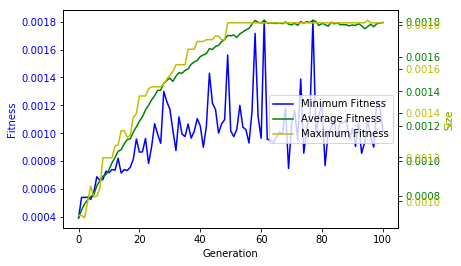

In [17]:
random.seed(42)

# cria populacao inicial
pop = toolbox.population(n=100)

# MU - numero de individuos selecionados para a prox geracao
# LAMBDA - numero de filhos a serem gerados
# CXPB - probabilidade de crossover
# MUTPB - probabilidade de mutacao
# NGEN - numero de geracoes
#MU, LAMBDA_, CXPB, MUTPB, NGEN = 5, 7, 0.7, 0.05, 100
MU, LAMBDA_, CXPB, MUTPB, NGEN = 5, 7, 0.6, 0.03, 100

#definindo quais stats devem ser mostrados no console
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("avg", numpy.mean)
stats.register("max", numpy.max)

#Algoritmos do livro “Evolutionary Computation 1 : Basic Algorithms and Operators”
#roda o algoritmo do capitulo 7
pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats=stats, verbose=True)

#Seleciona o melhor individuo da populacao resultante
best_ind = tools.selSPEA2(pop, 1)

#Imprime as informações do melhor individuo
melhor = decode(best_ind[0])
print('\nMELHOR INDIVIDUO:\n {}'.format(melhor))

#conta os caminhoes por rota para comparar com o ideal
resultado_caminhoes = dict((rota,len([r for r in melhor if rota in r] )) for rota in rotas) 
resultado_demanda = dict((k,v*carga_mes[k]) for k,v in resultado_caminhoes.items())

print('\nSOLUÇÃO ESPERADA PARA ATENDER A DEMANDA[DEMANDA]:\n {}'.format(demandas))
print('\nSOLUÇÃO ESPERADA PARA ATENDER A DEMANDA[CAMINHOES]:\n {}'.format(caminhoes_mes))

#dict((k,v*carga_mes[k]) for k,v in resultado.items())
print('\nSOLUÇÃO ENCONTRADA[DEMANDA]:\n {}'.format(resultado_demanda))
print('\nSOLUÇÃO ENCONTRADA[CAMINHOES]:\n {}'.format(resultado_caminhoes))

erro = sum((demandas[r]-resultado_demanda[r]) for r in rotas if demandas[r]-resultado_demanda[r] > 0)
divergencia = erro*100/sum(demandas.values())

rendimento = sum((remuneracoes[k]*carga_mes[k]/11) for k in melhor if k)
despesa = sum((custos[k]*carga_mes[k]/11) for k in melhor if k)
lucro = rendimento-despesa

print('\nDIVERGENCIA = {}%'.format(round(divergencia,2)))
print('\nLUCRO = {}'.format(round(lucro,2)))

#Plota gráfico
plot_log(logbook)

## ====TESTES====

In [ ]:
a = [0,0,0,1,1,
     1,1,1,1,0,
     1,0,1,0,1,
     0,1,0,1,0,
     1,0,1,1,1,
     1,1,1,1,1,
     1,1,1,1,1,
     0,0,1,0,0]
b = decode(a,len(a),5)
print(b)
print(sum(1 for i in b if i)) #contagem de caminhoes
c = [r for r in b if 'HYD' in r] #filtro
#print(c)


print(demandas)
print()
print(carga_mes)
print()
print(caminhoes_mes)
total =  sum(caminhoes_mes.values())

print(total)
    
#print(int(3.5))

In [ ]:
print(abs(-2))

In [ ]:
a = numpy.array([1,2,3])
b = numpy.array([1,4,1])
c = sum(abs(a-b))
print(c)